**Importing Necessary Libraries**

In [197]:
#importing necessary
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import plotly.graph_objects as go
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors as mcolors
from scipy.stats import linregress
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from tabulate import tabulate
from collections import Counter

%matplotlib inline

In [198]:
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

In [199]:
#importing data for the analysis
data = pd.read_csv('/content/data.csv', encoding="ISO-8859-1")

**Understanding the data more**

In [200]:
data.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom

In [201]:
data.describe()

Quantity      UnitPrice     CustomerID
count  541909.000000  541909.000000  406829.000000
mean        9.552250       4.611114   15287.690570
std       218.081158      96.759853    1713.600303
min    -80995.000000  -11062.060000   12346.000000
25%         1.000000       1.250000   13953.000000
50%         3.000000       2.080000   15152.000000
75%        10.000000       4.130000   16791.000000
max     80995.000000   38970.000000   18287.000000

In [202]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [203]:
# generate summary statistics
# Summary statistics for numerical variables
data.describe().T


count          mean          std       min       25%       50%  \
Quantity    541909.0      9.552250   218.081158 -80995.00      1.00      3.00   
UnitPrice   541909.0      4.611114    96.759853 -11062.06      1.25      2.08   
CustomerID  406829.0  15287.690570  1713.600303  12346.00  13953.00  15152.00   

                 75%      max  
Quantity       10.00  80995.0  
UnitPrice       4.13  38970.0  
CustomerID  16791.00  18287.0

In [204]:
# Summary statistics for categorical variables
data.describe(include='object').T

count unique                                 top    freq
InvoiceNo    541909  25900                              573585    1114
StockCode    541909   4070                              85123A    2313
Description  540455   4223  WHITE HANGING HEART T-LIGHT HOLDER    2369
InvoiceDate  541909  23260                    10/31/2011 14:41    1114
Country      541909     38                      United Kingdom  495478

In [205]:
data.shape

(541909, 8)

**Data Cleaning**

1) Missing Values

In [206]:
# Calculating missing values for each column
missing_data = data.isnull().sum()

In [207]:
missing_percentage = (missing_data[missing_data > 0] / data.shape[0]) * 100

missing_percentage.sort_values(ascending=True, inplace=True)

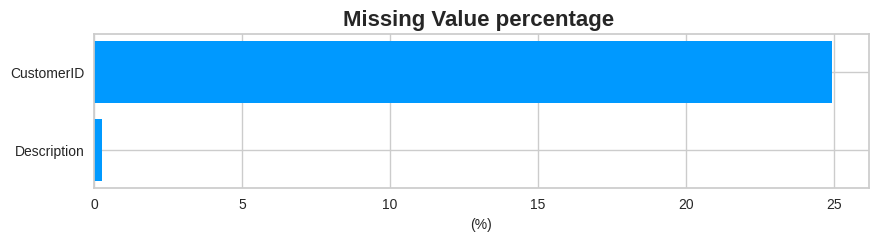

In [208]:
# Plotting the bar chart to display the missing values
fig, ax = plt.subplots(figsize=(10, 2))
ax.barh(missing_percentage.index, missing_percentage, color='#0099ff')

# title and xlabel
plt.title("Missing Value percentage ", fontweight='bold', fontsize=16)
plt.xlabel('(%)', fontsize=10)
plt.show()

In [209]:
# Extracting rows with missing values in 'CustomerID' or 'Description' columns
data[data['CustomerID'].isnull() | data['Description'].isnull()].head()

InvoiceNo StockCode                      Description  Quantity  \
622     536414     22139                              NaN        56   
1443    536544     21773  DECORATIVE ROSE BATHROOM BOTTLE         1   
1444    536544     21774  DECORATIVE CATS BATHROOM BOTTLE         2   
1445    536544     21786               POLKADOT RAIN HAT          4   
1446    536544     21787            RAIN PONCHO RETROSPOT         2   

          InvoiceDate  UnitPrice  CustomerID         Country  
622   12/1/2010 11:52       0.00         NaN  United Kingdom  
1443  12/1/2010 14:32       2.51         NaN  United Kingdom  
1444  12/1/2010 14:32       2.51         NaN  United Kingdom  
1445  12/1/2010 14:32       0.85         NaN  United Kingdom  
1446  12/1/2010 14:32       1.66         NaN  United Kingdom

CustomerID (24.00% missing values):With nearly a quarter of CustomerID data missing, removing these rows to avoid bias in customer clustering and recommendations.
Description (0.25% missing values): Due to minor but inconsistent missing descriptions, removing these rows to maintain data quality and accuracy in analyses.

In [210]:
# To remove rows with missing values in 'CustomerID' and 'Description' columns
data = data.dropna(subset=['CustomerID', 'Description'])
# Verifying the removal of missing values
data.isnull().sum().sum()

0

2) Duplicates

In [211]:
# Finding duplicate rows
duplicate_rows = data[data.duplicated(keep=False)]

In [212]:
# Sorting the data by certain columns to see the duplicate rows next to each other
sorting_duplicate_rows = duplicate_rows.sort_values(by=['InvoiceNo', 'StockCode', 'Description', 'CustomerID', 'Quantity'])

In [213]:
# extracting the first 10 records
sorting_duplicate_rows.head(10)

InvoiceNo StockCode                       Description  Quantity  \
494    536409     21866       UNION JACK FLAG LUGGAGE TAG         1   
517    536409     21866       UNION JACK FLAG LUGGAGE TAG         1   
485    536409     22111      SCOTTIE DOG HOT WATER BOTTLE         1   
539    536409     22111      SCOTTIE DOG HOT WATER BOTTLE         1   
489    536409     22866     HAND WARMER SCOTTY DOG DESIGN         1   
527    536409     22866     HAND WARMER SCOTTY DOG DESIGN         1   
521    536409     22900   SET 2 TEA TOWELS I LOVE LONDON          1   
537    536409     22900   SET 2 TEA TOWELS I LOVE LONDON          1   
578    536412     21448         12 DAISY PEGS IN WOOD BOX         1   
598    536412     21448         12 DAISY PEGS IN WOOD BOX         1   

         InvoiceDate  UnitPrice  CustomerID         Country  
494  12/1/2010 11:45       1.25     17908.0  United Kingdom  
517  12/1/2010 11:45       1.25     17908.0  United Kingdom  
485  12/1/2010 11:45       4.95     17908.0  United Kingdom  
539  12/1/2010 11:45       4.95     17908.0  United Kingdom  
489  12/1/2010 11:45       2.10     17908.0  United Kingdom  
527  12/1/2010 11:45       2.10     17908.0  United Kingdom  
521  12/1/2010 11:45       2.95     17908.0  United Kingdom  
537  12/1/2010 11:45       2.95     17908.0  United Kingdom  
578  12/1/2010 11:49       1.65     17920.0  United Kingdom  
598  12/1/2010 11:49       1.65     17920.0  United Kingdom

In [214]:
#dropping the duplicate rows
data.drop_duplicates(inplace=True)

In [215]:
data.shape


(401604, 8)

3) Stockcode discrepancies

In [216]:
#number of unique stock codes and the frequency
unique_stock_codes = data['StockCode'].nunique()

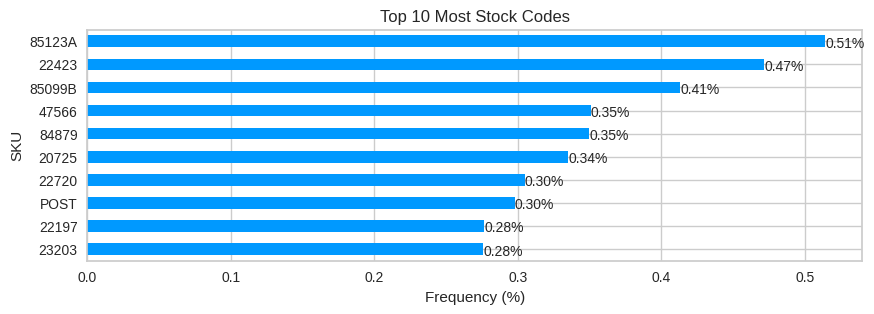

In [217]:
# Top 10 most frequent stock codes
top_10_stock_codes = data['StockCode'].value_counts(normalize=True).head(10) * 100

# Plotting the top 10 most frequent stock codes
plt.figure(figsize=(10, 3))
top_10_stock_codes.plot(kind='barh', color='#0099ff')

# Adding the percentage frequency on the bars
for index, value in enumerate(top_10_stock_codes):
    plt.text(value, index+0.25, f'{value:.2f}%', fontsize=10)

plt.title('Top 10 Most Stock Codes')
plt.xlabel('Frequency (%)')
plt.ylabel('SKU')
plt.gca().invert_yaxis()
plt.show()

In [218]:
# Finding the number of numeric characters in each unique stock code
unique_stock_codes = data['StockCode'].unique()
numeric_char_counts_in_unique_codes = pd.Series(unique_stock_codes).apply(lambda x: sum(c.isdigit() for c in str(x))).value_counts()

# Printing the value counts for unique stock codes
print("Value counts of numeric character frequencies in unique stock codes:")
print("-"*70)
print(numeric_char_counts_in_unique_codes)

Value counts of numeric character frequencies in unique stock codes:
----------------------------------------------------------------------
5    3676
0       7
1       1
Name: count, dtype: int64


In [219]:
# Finding and printing the stock codes with 0 and 1 numeric characters
anomalous_stock_codes = [code for code in unique_stock_codes if sum(c.isdigit() for c in str(code)) in (0, 1)]

# Printing each stock code on a new line
print("Error stock codes:")
print("-"*22)
for code in anomalous_stock_codes:
    print(code)

Error stock codes:
----------------------
POST
D
C2
M
BANK CHARGES
PADS
DOT
CRUK


In [220]:
#the percentage of records with these anomalous stock codes:

# Calculating the percentage of records with these stock codes
percentage_anomalous = (data['StockCode'].isin(anomalous_stock_codes).sum() / len(data)) * 100

# Printing the percentage
print(f"The percentage of records with anomalous stock codes in the dataset is: {percentage_anomalous:.2f}%")#

The percentage of records with anomalous stock codes in the dataset is: 0.48%


In [221]:
# The approach will be to identify and exclude rows containing these irregular stock
# codes from the dataset prior to advancing with further analysis and model development.

# Removing rows with anomalous stock codes from the dataset
data = data[~data['StockCode'].isin(anomalous_stock_codes)]
# Getting the number of rows in the dataframe
data.shape[0]

399689

4) Unit price anomalies

In [222]:
# working on Zero Unit Prices
data['UnitPrice'].describe()


count    399689.000000
mean          2.907457
std           4.451881
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max         649.500000
Name: UnitPrice, dtype: float64

The minimum unit price is zero, indicating some transactions might involve free items or errors in data entry.

In [223]:
data[data['UnitPrice']==0].describe()[['Quantity']]


Quantity
count     33.000000
mean     420.515152
std     2176.713608
min        1.000000
25%        2.000000
50%       11.000000
75%       36.000000
max    12540.000000

In [224]:
# Removing records with a unit price of zero to avoid potential data entry errors
data = data[data['UnitPrice'] > 0]

5) Reseting the index

In [225]:
# Resetting the index of the cleaned dataset
data.reset_index(drop=True, inplace=True)
# Getting the number of rows in the dataframe
rows_count = data.shape[0]
print(f"Number of rows in the cleaned dataset: {rows_count}")


Number of rows in the cleaned dataset: 399656


Some more information about the dataset

Description

In [226]:
# Working with description column
# Calculate the occurrence of each unique description and sort them
description_counts = data['Description'].value_counts()

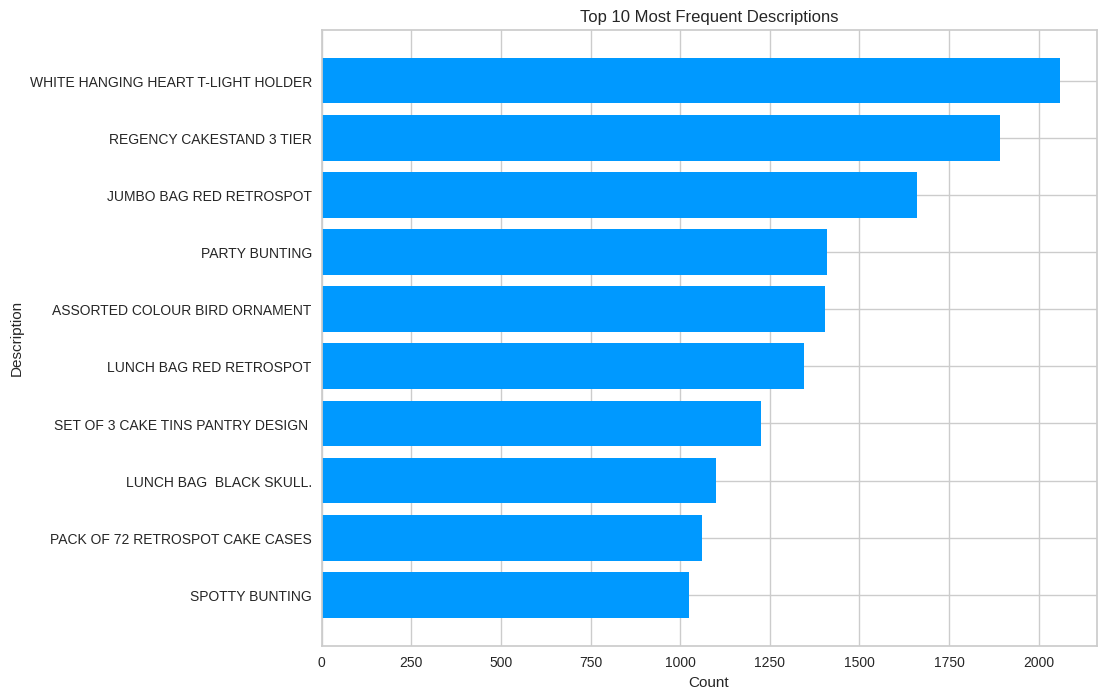

In [227]:
# Get the top 10 descriptions
top_10_descriptions = description_counts[:10]
# Plotting
plt.figure(figsize=(10,8))
plt.barh(top_10_descriptions.index[::-1], top_10_descriptions.values[::-1], color='#0099ff')

# Adding labels and title
plt.xlabel('Count')
plt.ylabel('Description')
plt.title('Top 10 Most Frequent Descriptions')

# Show the plot
plt.show()


**R F M Analysis**

Understanding the data more by plotting the country wise distribution of the sales some other KPIs such as Average orders, monthly/yearly, understanding how many active customers were there and then calculating Recency, Frequency and Monetory value generated by customer purchase


1) Country Wise distribution of sales

In [228]:
# calculate Revenue for each row
data['Revenue'] = data['UnitPrice'] * data['Quantity']

# we look at the revenue by country
revenue_country = pd.DataFrame(data.groupby('Country')['Revenue'].agg(sum).sort_values(ascending=False)).reset_index()

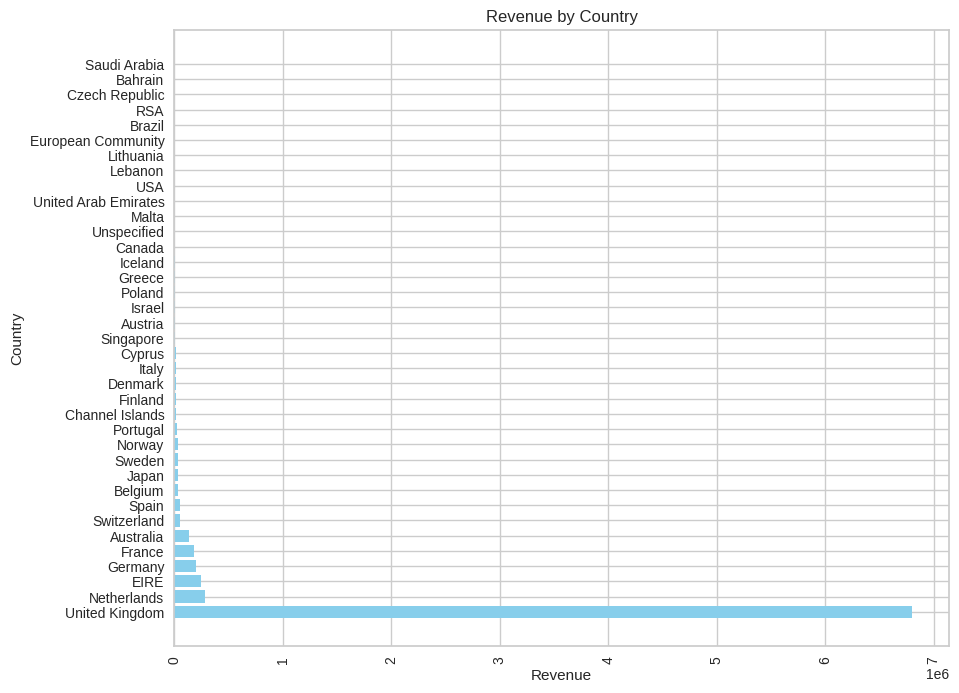

In [229]:
plt.figure(figsize=(10, 8))
plt.barh(revenue_country['Country'], revenue_country['Revenue'], color='skyblue')
plt.xlabel('Revenue')
plt.ylabel('Country')
plt.title('Revenue by Country')
plt.xticks(rotation=90)  # Invert y axis for better visibility with large number of countries
plt.show()

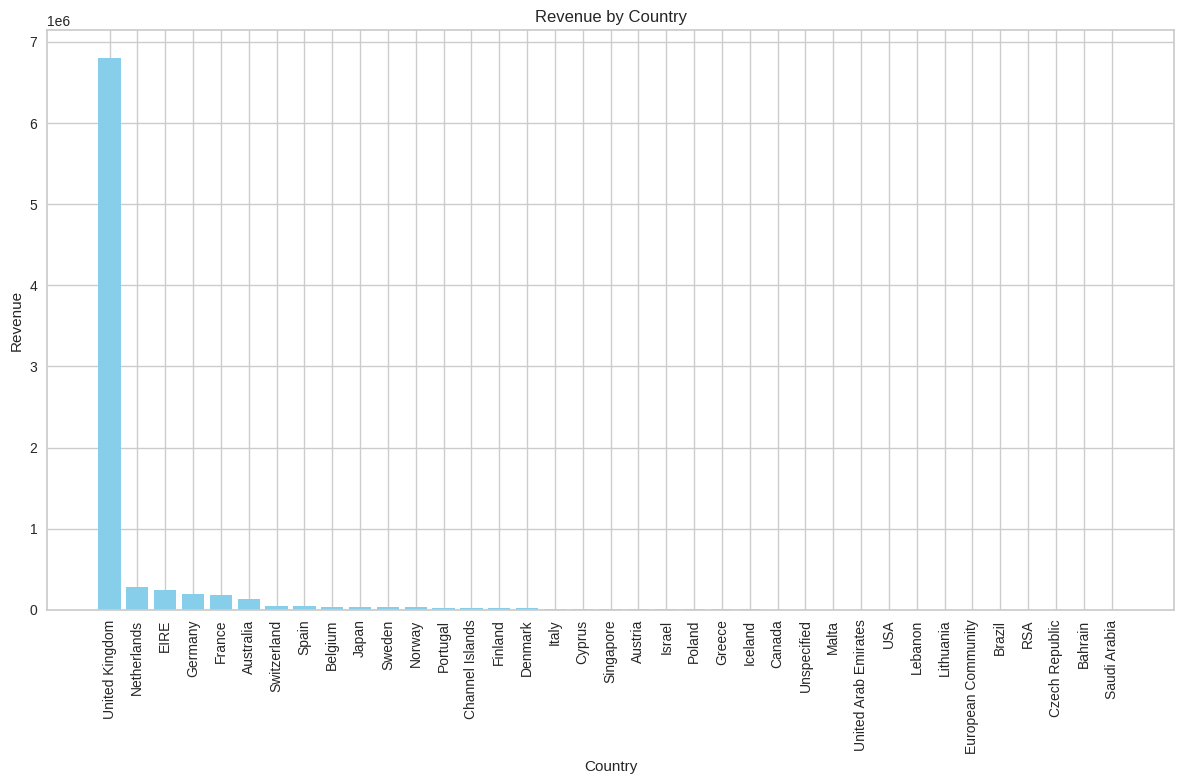

In [230]:
plt.figure(figsize=(12, 8))  # Set figure size
plt.bar(revenue_country['Country'], revenue_country['Revenue'], color='skyblue')  # Create a bar chart
plt.xlabel('Country')  # Label x-axis
plt.ylabel('Revenue')  # Label y-axis
plt.title('Revenue by Country')  # Add a title
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility

# Show the plot
plt.tight_layout()  # Adjust layout to not cut off labels
plt.show()

In [231]:
# calculate Revenue for each row
data['Revenue'] = data['UnitPrice'] * data['Quantity']

#taking uk data as it constitute of majority of the data in the dataset
uk_data = data[data['Country'] == 'United Kingdom']

uk_data.shape


(356090, 9)

In [232]:
#geographical representation

data['Country'].value_counts(normalize=True).head()


Country
United Kingdom    0.890991
Germany           0.022720
France            0.020398
EIRE              0.018436
Spain             0.006160
Name: proportion, dtype: float64

**89% of transactions come from the United Kingdom hence creating a seperate dataframe for UK data and then using that dataframe for analysis**

In [233]:
uk_data
#now calculating Monthly Revenue and create a new dataframe with YearMonth and Revenue columns

InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
399636    581585     22466       FAIRY TALE COTTAGE NIGHT LIGHT        12   
399637    581586     22061  LARGE CAKE STAND  HANGING STRAWBERY         8   
399638    581586     23275     SET OF 3 HANGING OWLS OLLIE BEAK        24   
399639    581586     21217        RED RETROSPOT ROUND CAKE TINS        24   
399640    581586     20685                DOORMAT RED RETROSPOT        10   

            InvoiceDate  UnitPrice  CustomerID         Country  Revenue  
0        12/1/2010 8:26       2.55     17850.0  United Kingdom    15.30  
1        12/1/2010 8:26       3.39     17850.0  United Kingdom    20.34  
2        12/1/2010 8:26       2.75     17850.0  United Kingdom    22.00  
3        12/1/2010 8:26       3.39     17850.0  United Kingdom    20.34  
4        12/1/2010 8:26       3.39     17850.0  United Kingdom    20.34  
...                 ...        ...         ...             ...      ...  
399636  12/9/2011 12:31       1.95     15804.0  United Kingdom    23.40  
399637  12/9/2011 12:49       2.95     13113.0  United Kingdom    23.60  
399638  12/9/2011 12:49       1.25     13113.0  United Kingdom    30.00  
399639  12/9/2011 12:49       8.95     13113.0  United Kingdom   214.80  
399640  12/9/2011 12:49       7.08     13113.0  United Kingdom    70.80  

[356090 rows x 9 columns]

In [234]:
# converting the type of InvoiceDate feature from string to datetime.
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# creating YearMonth feature to simplify reporting and visualization
data['InvoiceYearMonth'] = data['InvoiceDate'].map(lambda date: 100*date.year + date.month).astype('category')

data = pd.DataFrame(data)

In [235]:
# calculate Revenue for each row
data['Revenue'] = data['UnitPrice'] * data['Quantity']

uk_data = data[data['Country'] == 'United Kingdom']

uk_data.shape

(356090, 10)

In [236]:
# create a new dataframe with YearMonth and Revenue columns
revenue = uk_data.groupby(['InvoiceYearMonth'])['Revenue'].sum().reset_index()
revenue.head()

InvoiceYearMonth    Revenue
0           201012  482093.29
1           201101  350690.39
2           201102  349535.15
3           201103  456174.94
4           201104  375468.33

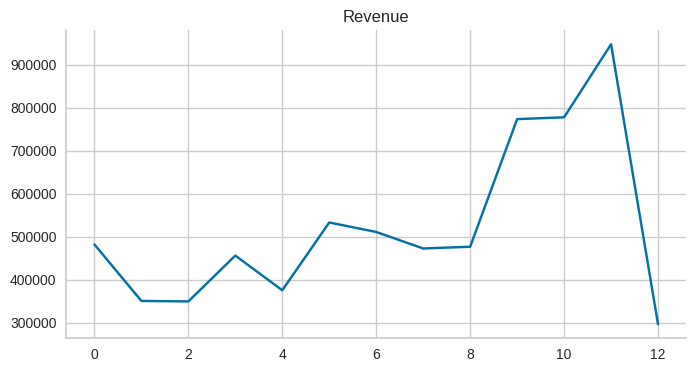

In [237]:
# @title Revenue

from matplotlib import pyplot as plt
revenue['Revenue'].plot(kind='line', figsize=(8, 4), title='Revenue')
plt.gca().spines[['top', 'right']].set_visible(False)

**Revenue by Invoice by Month**

<Axes: xlabel='InvoiceYearMonth'>

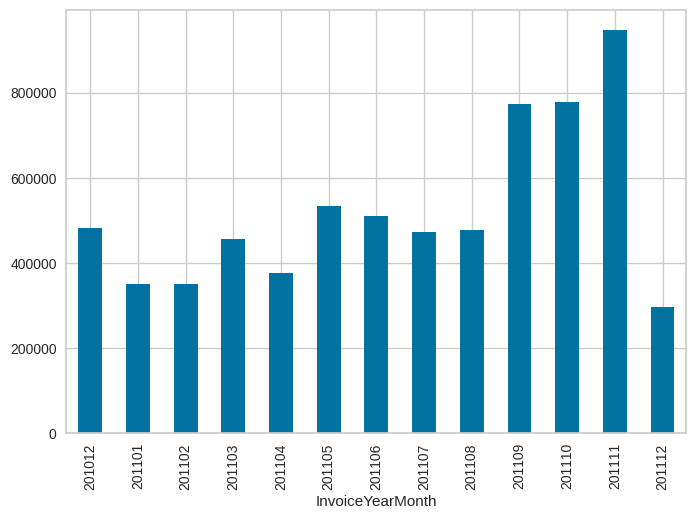

In [238]:
# @title Average Revenue by InvoiceYearMonth

revenue.groupby('InvoiceYearMonth')['Revenue'].mean().plot(kind='bar')

In [239]:
# The chart indicates an upward trend in revenue leading up to November 2011.
# Until August 2011, monthly revenue consistently ranged between 400K and 600K.
# From September onwards, there was a significant increase, with revenue peaking at 1+ million in November 2011.

**Monthly Growth**

In [240]:
# calculate the monthly growth
revenue['MonthlyGrowth'] = revenue['Revenue'].pct_change()

revenue.head()

InvoiceYearMonth    Revenue  MonthlyGrowth
0           201012  482093.29            NaN
1           201101  350690.39      -0.272567
2           201102  349535.15      -0.003294
3           201103  456174.94       0.305090
4           201104  375468.33      -0.176920

September saw an exceptional increase, with revenue growing by nearly 60% compared to the previous month.November also recorded a robust growth of 46.2%. Both March and May experienced growth of over 30%, which could be attributed to the weaker performance in the preceding months. January and April of 2011 were months of poor performance.

**Active Customers**

In [241]:
# counting unique customer ids to create monthly active customers dataframe
monthly_active = uk_data.groupby('InvoiceYearMonth')['CustomerID'].nunique().reset_index()
monthly_active.columns = ['InvoiceYearMonth','ActiveCustomers']

# displaying the dataframe
monthly_active

InvoiceYearMonth  ActiveCustomers
0            201012              870
1            201101              682
2            201102              708
3            201103              920
4            201104              816
5            201105              983
6            201106              941
7            201107              888
8            201108              864
9            201109             1171
10           201110             1283
11           201111             1544
12           201112              615

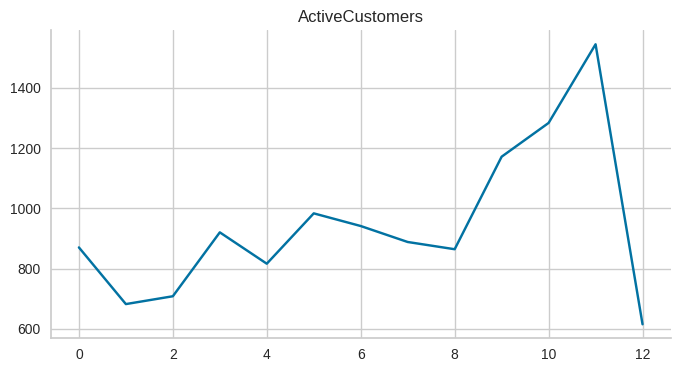

In [242]:
# @title ActiveCustomers

from matplotlib import pyplot as plt
monthly_active['ActiveCustomers'].plot(kind='line', figsize=(8, 4), title='ActiveCustomers')
plt.gca().spines[['top', 'right']].set_visible(False)

**Monthly orders**

In [243]:
#number of orders by using InvoiceNo feature
monthly_orders = uk_data.groupby('InvoiceYearMonth')['InvoiceNo'].nunique().reset_index()
monthly_orders.columns = ['InvoiceYearMonth','Orders']

# printing the dataframe
monthly_orders

InvoiceYearMonth  Orders
0            201012    1558
1            201101    1085
2            201102    1057
3            201103    1426
4            201104    1250
5            201105    1641
6            201106    1519
7            201107    1407
8            201108    1329
9            201109    1813
10           201110    1958
11           201111    2715
12           201112     823

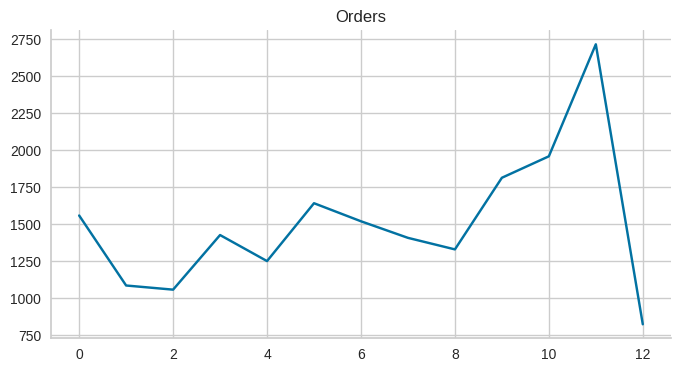

In [244]:
# @title Orders

from matplotlib import pyplot as plt
monthly_orders['Orders'].plot(kind='line', figsize=(8, 4), title='Orders')
plt.gca().spines[['top', 'right']].set_visible(False)

**Recency Analysis**

In [245]:
import numpy as np # linear algebra
import pandas as pd # data processing
import os # manipulate paths
from datetime import date # supplies classes for manipulating dates
from time import strftime # convert time to a string as specified by the format argument

from sklearn.cluster import KMeans # K-Means clustering

import seaborn as sns # to create visualisations
import matplotlib.pyplot as plt
%matplotlib inline
import plotly
import plotly.express as px
import plotly.graph_objs as go
import cufflinks as cf

from plotly.offline import init_notebook_mode, iplot
init_notebook_mode()
cf.go_offline()

import warnings # remove warning messages
warnings.filterwarnings('ignore')


# function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

In [246]:
# Recency Calculation
# Recency measures how recently a customer made a purchase.
# last invoice date for each customer and calculate the number of days since they are not active

# creating a generic user dataframe to keep CustomerID and new segmentation scores
data_customers = pd.DataFrame(uk_data['CustomerID'].unique())
data_customers.columns = ['CustomerID']

# creating a dataframe with the latest order date
lastest_purchase = uk_data.groupby('CustomerID').InvoiceDate.max().reset_index()

# lastest_purchase.head()
lastest_purchase.columns = ['CustomerID','LastestPurchaseDate']

# counting the number of days customers have been inactive for
lastest_purchase['Recency'] = (lastest_purchase['LastestPurchaseDate'].max() - lastest_purchase['LastestPurchaseDate']).dt.days

# merging the two dataframes
data_customers = pd.merge(data_customers, lastest_purchase[['CustomerID','Recency']], on='CustomerID')

data_customers.head()

CustomerID  Recency
0     17850.0      301
1     13047.0       45
2     13748.0       95
3     15100.0      329
4     15291.0       25

In [247]:
# converting customer_id to int from float as the customer_id cannot have decimals
data_customers['CustomerID'] = data_customers['CustomerID'].astype('int64')

In [248]:
data_customers.dtypes

CustomerID    int64
Recency       int64
dtype: object

In [249]:
data_customers.head()

CustomerID  Recency
0       17850      301
1       13047       45
2       13748       95
3       15100      329
4       15291       25

In [250]:
data_customers['Recency'].describe()

count    3942.000000
mean       90.996449
std       100.559278
min         0.000000
25%        16.000000
50%        49.000000
75%       143.000000
max       373.000000
Name: Recency, dtype: float64

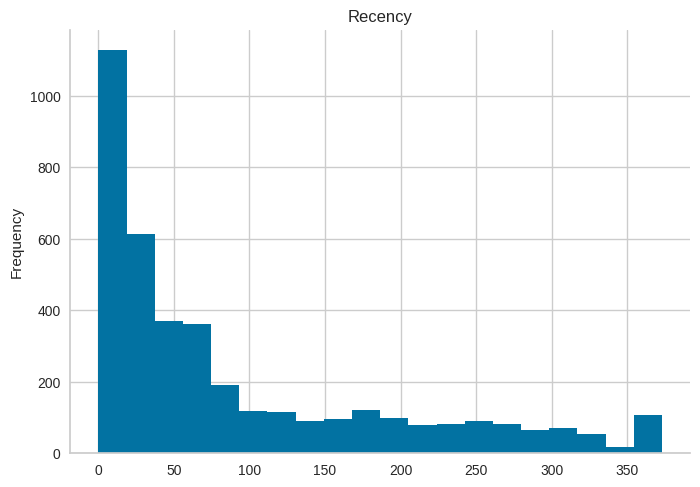

In [251]:
# @title Recency

from matplotlib import pyplot as plt
data_customers['Recency'].plot(kind='hist', bins=20, title='Recency')
plt.gca().spines[['top', 'right',]].set_visible(False)

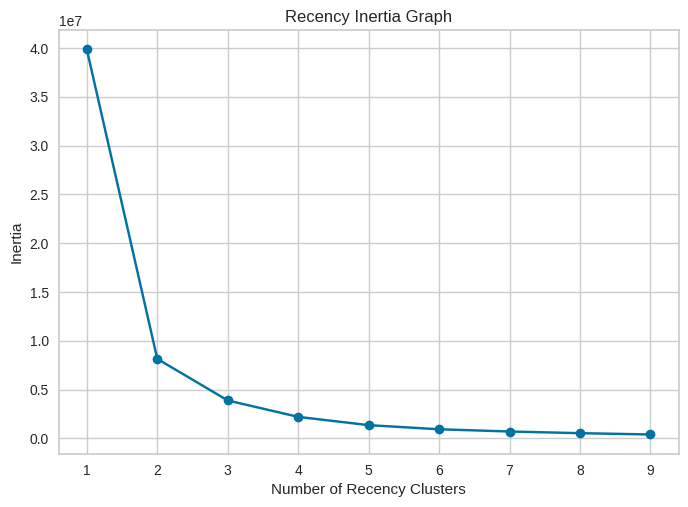

In [252]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Initialize a dictionary to store scores
scores = {}

# Extract the 'Recency' data as a DataFrame
recency_data = data_customers[['Recency']]

# Loop over a range of k values to test different numbers of clusters
for k in range(1, 10):
    # Initialize and fit the KMeans model
    kmeans = KMeans(n_clusters=k, random_state=101)
    kmeans.fit(recency_data)

    # Store the model's inertia in the scores dictionary
    scores[k] = kmeans.inertia_

# Plotting the inertia values to find the optimal number of clusters
plt.figure()
plt.plot(list(scores.keys()), list(scores.values()), marker='o')
plt.title('Recency Inertia Graph')
plt.xlabel("Number of Recency Clusters")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()


The optimal number of clusters in a K-means clustering scenario is determined by the "elbow method." Looking at the inertia graph the elbow method suggests that we should choose the number of clusters at the point where the inertia begins to decrease more slowly. The "elbow" is where the plot bends — this indicates that adding more clusters beyond this point doesn't provide much better modeling of the data.

From the graph, it appears that the inertia drops significantly as the number of clusters increases from 1 to 2 and then to 3. After 3 clusters, the rate of decrease in inertia slows down, and the line starts to flatten out, suggesting that additional clusters are not capturing as much variability in the data.

Therefore, based on the graph, the optimal number of recency clusters could be 3 since it's the point just before the rate of decrease in inertia becomes more gradual. After this point, the gains in compactness of clusters are minimal, indicating that 3 clusters are a good balance between the complexity of the model and the fit to the data.

In [253]:
# the KMeans clustering model with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=101)

# Fit the model on the 'Recency' column and predict cluster labels
data_customers['RecencyCluster'] = kmeans.fit_predict(data_customers[['Recency']])

# Apply the order_cluster function to reorder the clusters
data_customers = order_cluster('RecencyCluster', 'Recency', data_customers, True)

# Display the dataframe (this line can be omitted if not running in an interactive environment)
data_customers


CustomerID  Recency  RecencyCluster
0          17850      301               2
1          15100      329               2
2          18074      373               2
3          16250      260               2
4          13747      373               2
...          ...      ...             ...
3937       17309       94               1
3938       16400       94               1
3939       14208       94               1
3940       13130       93               1
3941       13210       93               1

[3942 rows x 3 columns]

In [254]:
# look at the recency by clusters
recency_clusters = data_customers.groupby('RecencyCluster')['Recency']
recency_clusters.describe()

count        mean        std    min    25%    50%     75%  \
RecencyCluster                                                               
0               2655.0   30.513748  25.171269    0.0    9.0   24.0   49.50   
1                726.0  154.707989  38.160317   93.0  120.0  155.0  186.75   
2                561.0  294.787879  45.444820  225.0  256.0  287.0  329.00   

                  max  
RecencyCluster         
0                92.0  
1               224.0  
2               373.0

Cluster 0:
Cluster 0 comprises 2,655 customers, representing those with the most recent engagements. The average recency for these customers is 30.5 days, with a standard deviation of 25.17 days, indicating variability in the recentness of their transactions. The recency values range from 0 days, showing very recent activity, to 92 days. Notably, 25% of these customers made a purchase within the last 9 days, half within 24 days, and 75% within 49.5 days.

Cluster 1:
This cluster consists of 726 customers who exhibit a mid-range purchasing recency with a mean of approximately 154.71 days. The standard deviation is 38.16 days, suggesting moderate variability around the mean. The minimum recency in this cluster is 93 days, and the maximum extends to 224 days. The distribution's quartiles show that 25% of the customers made a purchase within the last 120 days, the median recency is 155 days, and 75% of the cluster engaged within 186.75 days.

Cluster 2:
Cluster 2 includes 561 customers and represents those with the longest intervals since their last purchase. The mean recency for this group is about 294.79 days, with a standard deviation of 45.44 days. These customers have a recency range from 225 to 373 days, indicating a substantial lapse since their last engagement. The quartile values reveal that 25% of these customers have a recency of up to 256 days, the median is 287 days, and 75% extend to a recency of 329 days. This cluster highlights customers at a higher risk of attrition, suggesting they may require targeted re-engagement strategies.

**Frequency Analysis**

In [255]:
# create dataframe with the number of orders for each customers
data_freq = uk_data.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
data_freq.columns = ['CustomerID','Frequency']
data_freq

CustomerID  Frequency
0        12346.0          2
1        12747.0         11
2        12748.0        217
3        12749.0          8
4        12820.0          4
...          ...        ...
3937     18280.0          1
3938     18281.0          1
3939     18282.0          3
3940     18283.0         16
3941     18287.0          3

[3942 rows x 2 columns]

In [256]:
data_customers.head()

CustomerID  Recency  RecencyCluster
0       17850      301               2
1       15100      329               2
2       18074      373               2
3       16250      260               2
4       13747      373               2

In [257]:
# add df_freq to data_customers
data_customers = pd.merge(data_customers, data_freq, on='CustomerID')

In [258]:
data_customers.head()

CustomerID  Recency  RecencyCluster  Frequency
0       17850      301               2         35
1       15100      329               2          6
2       18074      373               2          1
3       16250      260               2          2
4       13747      373               2          1

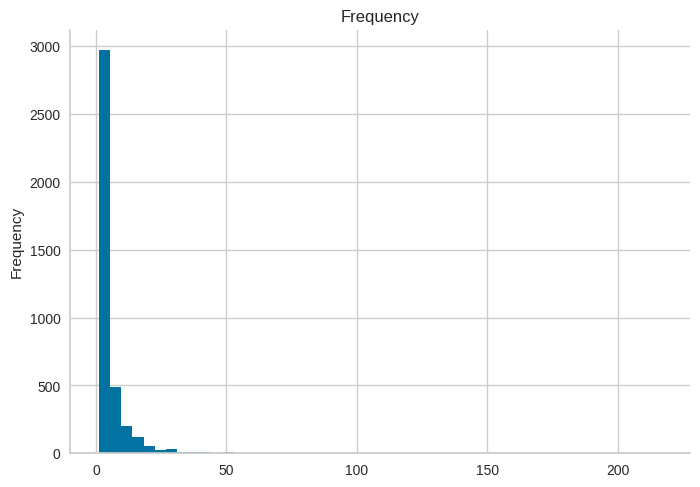

In [259]:
# @title Frequency

from matplotlib import pyplot as plt
data_customers['Frequency'].plot(kind='hist', bins=50, title='Frequency')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [260]:
data_freq.describe()

CustomerID    Frequency
count   3942.000000  3942.000000
mean   15561.767123     4.967275
std     1576.658994     8.480806
min    12346.000000     1.000000
25%    14208.250000     1.000000
50%    15570.500000     3.000000
75%    16912.750000     5.000000
max    18287.000000   217.000000

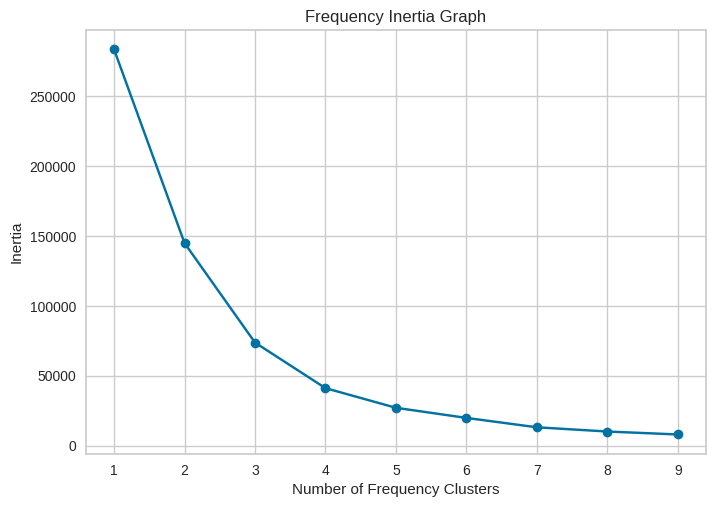

In [261]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Initialize a dictionary to store inertia values for different k values
freq_scores = {}

# Select the 'Frequency' column for clustering
frequency_data = data_customers[['Frequency']]

# Loop over a range of k values to determine the best number of clusters
for k in range(1, 10):
    # Create a KMeans instance with k clusters and a fixed random state
    kmeans = KMeans(n_clusters=k, random_state=101)

    # Fit the KMeans model to the frequency data and compute inertia
    freq_scores[k] = kmeans.fit(frequency_data).inertia_

# Plot the inertia values to visualize the "elbow"
plt.figure()
plt.plot(list(freq_scores.keys()), list(freq_scores.values()), marker='o')
plt.title('Frequency Inertia Graph')
plt.xlabel('Number of Frequency Clusters')
plt.ylabel('Inertia')
plt.xticks(range(1, 10))  # Set x-ticks to be explicit numbers of clusters for clarity
plt.grid(True)
plt.show()

In [262]:
# build 4 clusters for frequency and add it to the customer dataframe
freq_kmeans = KMeans(n_clusters=4)
freq_kmeans.fit(data_customers[['Frequency']])
data_customers['FrequencyCluster'] = freq_kmeans.predict(data_customers[['Frequency']])

# apply order_cluster function
data_customers = order_cluster('FrequencyCluster','Frequency',data_customers,True)
data_customers

CustomerID  Recency  RecencyCluster  Frequency  FrequencyCluster
0          17850      301               2         35                 2
1          14688        7               0         27                 2
2          16029       38               0         66                 2
3          17511        2               0         45                 2
4          13408        1               0         75                 2
...          ...      ...             ...        ...               ...
3937       15311        0               0        118                 3
3938       12748        0               0        217                 3
3939       17841        1               0        169                 3
3940       14606        0               0        125                 3
3941       13089        2               0        118                 3

[3942 rows x 5 columns]

In [263]:
# look at the frequency by clusters
frequency_clusters = data_customers.groupby('FrequencyCluster')['Frequency']
frequency_clusters.describe()

count        mean        std    min    25%    50%    75%  \
FrequencyCluster                                                              
0                 3394.0    2.807307   1.975236    1.0    1.0    2.0    4.0   
1                  461.0   13.442516   4.099768    9.0   10.0   12.0   16.0   
2                   82.0   37.914634  12.519813   26.0   29.0   33.0   43.0   
3                    5.0  149.400000  43.362426  118.0  118.0  125.0  169.0   

                    max  
FrequencyCluster         
0                   8.0  
1                  25.0  
2                  88.0  
3                 217.0

In [264]:
# calculate the revenue for each row in the main dataframe uk_data
uk_data['Revenue'] = uk_data['UnitPrice'] * uk_data['Quantity']

In [265]:
# create a new dataframe for each customer's revenue
data_revenue = uk_data.groupby('CustomerID')['Revenue'].sum().reset_index()

In [266]:
# merge it with the custoemr dataframe
data_customers = pd.merge(data_customers, data_revenue, on='CustomerID')
data_revenue

CustomerID   Revenue
0        12346.0      0.00
1        12747.0   4196.01
2        12748.0  29819.99
3        12749.0   3818.20
4        12820.0    942.34
...          ...       ...
3937     18280.0    180.60
3938     18281.0     80.82
3939     18282.0    176.60
3940     18283.0   2039.58
3941     18287.0   1837.28

[3942 rows x 2 columns]

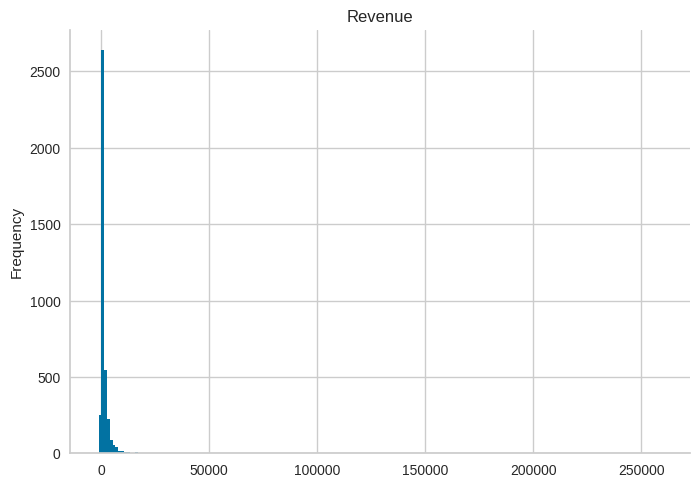

In [267]:
# @title Revenue

from matplotlib import pyplot as plt
data_revenue['Revenue'].plot(kind='hist', bins=200, title='Revenue')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [268]:
data_customers['Revenue'].describe()


count      3942.000000
mean       1725.658442
std        6640.231172
min       -1192.200000
25%         283.530000
50%         625.755000
75%        1520.382500
max      259657.300000
Name: Revenue, dtype: float64

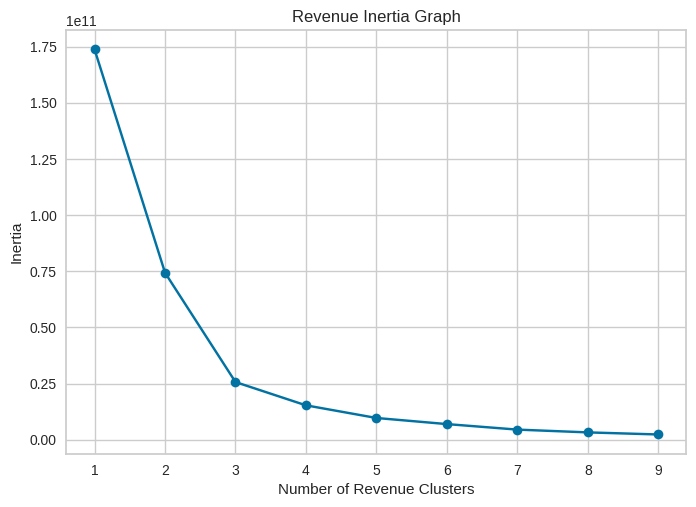

In [269]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Initialize a dictionary to store inertia values for different k values
revenue_scores = {}

# Extract the 'Revenue' data for clustering
revenue_data = data_customers[['Revenue']]

# Loop over a range of k values to find the optimal number of clusters
for k in range(1, 10):
    # Initialize KMeans with k clusters, fit it to the revenue data, and store the inertia
    kmeans = KMeans(n_clusters=k, random_state=101)
    kmeans.fit(revenue_data)
    revenue_scores[k] = kmeans.inertia_

# Plotting the inertia scores
plt.figure()
plt.plot(list(revenue_scores.keys()), list(revenue_scores.values()), marker='o')
plt.title('Revenue Inertia Graph')
plt.xlabel('Number of Revenue Clusters')
plt.ylabel('Inertia')
plt.xticks(range(1, 10))  # Set explicit x-ticks for clarity
plt.grid(True)  # Add a grid for easier interpretation
plt.show()

In [270]:
# build 3 clusters for revenue and add it to the customer dataframe
revenue_kmeans = KMeans(n_clusters=3)
revenue_kmeans.fit(data_customers[['Revenue']])
data_customers['RevenueCluster'] = revenue_kmeans.predict(data_customers[['Revenue']])

# apply order_cluster function
data_customers = order_cluster('RevenueCluster','Revenue',data_customers,True)
data_customers

CustomerID  Recency  RecencyCluster  Frequency  FrequencyCluster  \
0          17850      301               2         35                 2   
1          14688        7               0         27                 2   
2          13767        1               0         52                 2   
3          14849       21               0         28                 2   
4          12921        3               0         50                 2   
...          ...      ...             ...        ...               ...   
3937       12748        0               0        217                 3   
3938       17841        1               0        169                 3   
3939       13089        2               0        118                 3   
3940       17450        7               0         49                 2   
3941       18102        0               0         60                 2   

        Revenue  RevenueCluster  
0       5303.48               0  
1       5055.61               0  
2      16945.71               0  
3       7904.28               0  
4      16389.74               0  
...         ...             ...  
3937   29819.99               1  
3938   39861.49               1  
3939   57322.13               1  
3940  189575.53               2  
3941  259657.30               2  

[3942 rows x 7 columns]

In [271]:
# look at the revenue by clusters
revenue_clusters = data_customers.groupby('RevenueCluster')['Revenue']
revenue_clusters.describe()

count           mean           std        min          25%  \
RevenueCluster                                                                
0               3912.0    1315.139363   2049.862606   -1192.20     281.2900   
1                 28.0   43160.270000  15856.651600   25185.84   29529.7125   
2                  2.0  224616.415000  49555.294805  189575.53  207095.9725   

                       50%          75%       max  
RevenueCluster                                     
0                  617.790    1482.5600   21535.9  
1                37986.185   53506.4075   88138.2  
2               224616.415  242136.8575  259657.3

In [272]:
# Calculate overall score
data_customers['OverallScore'] = data_customers['RecencyCluster'] + data_customers['FrequencyCluster'] + data_customers['RevenueCluster']

# Group by 'OverallScore' and calculate the mean for 'Recency', 'Frequency', and 'Revenue'
mean_values = data_customers.groupby('OverallScore')[['Recency', 'Frequency', 'Revenue']].mean()
mean_values


Recency   Frequency       Revenue
OverallScore                                      
0              34.465695    3.312030    994.341429
1             102.321930    6.562281   1860.108693
2             258.553159    5.221880   1844.779769
3              33.666667   49.833333  40443.162778
4              44.428571  109.428571  91546.301429

The analysis of the table indicates that customers with an OverallScore of 4 are more valuable than those with an OverallScore of 0.

0: Low Value
1 and 2: Mid Value
3 and 4: High Value


In [273]:
# apply this naming on our dataframe
data_customers['Segment'] = 'Red - Low value'
data_customers.loc[data_customers['OverallScore']>0,'Segment'] = 'Yellow - Mid value'
data_customers.loc[data_customers['OverallScore']>2,'Segment'] = 'Green - High Vlaue'

In [274]:
data_customers

CustomerID  Recency  RecencyCluster  Frequency  FrequencyCluster  \
0          17850      301               2         35                 2   
1          14688        7               0         27                 2   
2          13767        1               0         52                 2   
3          14849       21               0         28                 2   
4          12921        3               0         50                 2   
...          ...      ...             ...        ...               ...   
3937       12748        0               0        217                 3   
3938       17841        1               0        169                 3   
3939       13089        2               0        118                 3   
3940       17450        7               0         49                 2   
3941       18102        0               0         60                 2   

        Revenue  RevenueCluster  OverallScore             Segment  
0       5303.48               0             4  Green - High Vlaue  
1       5055.61               0             2  Yellow - Mid value  
2      16945.71               0             2  Yellow - Mid value  
3       7904.28               0             2  Yellow - Mid value  
4      16389.74               0             2  Yellow - Mid value  
...         ...             ...           ...                 ...  
3937   29819.99               1             4  Green - High Vlaue  
3938   39861.49               1             4  Green - High Vlaue  
3939   57322.13               1             4  Green - High Vlaue  
3940  189575.53               2             4  Green - High Vlaue  
3941  259657.30               2             4  Green - High Vlaue  

[3942 rows x 9 columns]

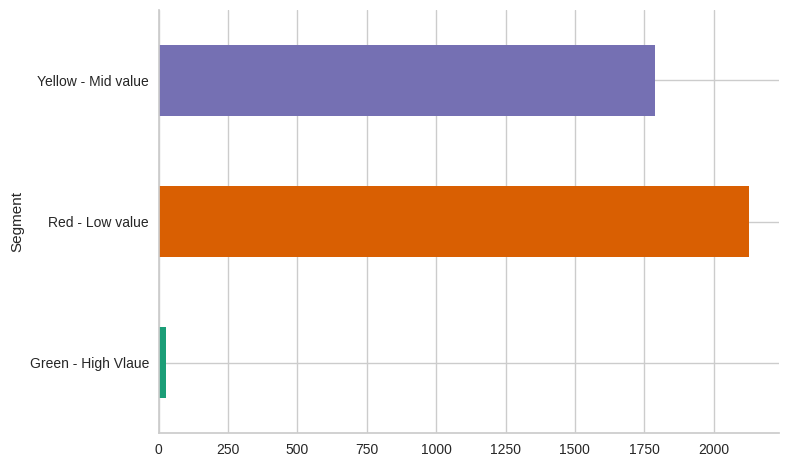

In [275]:
from matplotlib import pyplot as plt
import seaborn as sns
data_customers.groupby('Segment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

**Product Diversity**

In [276]:
# Calculate the number of unique products purchased by each customer
unique_products_purchased = data.groupby('CustomerID')['StockCode'].nunique().reset_index()
unique_products_purchased.rename(columns={'StockCode': 'Unique_Products_Purchased'}, inplace=True)

# Merge the new feature into the customer_data dataframe
data_customers = pd.merge(data_customers, unique_products_purchased, on='CustomerID')

# Display the first few rows of the customer_data dataframe
data_customers.head()

CustomerID  Recency  RecencyCluster  Frequency  FrequencyCluster   Revenue  \
0       17850      301               2         35                 2   5303.48   
1       14688        7               0         27                 2   5055.61   
2       13767        1               0         52                 2  16945.71   
3       14849       21               0         28                 2   7904.28   
4       12921        3               0         50                 2  16389.74   

   RevenueCluster  OverallScore             Segment  Unique_Products_Purchased  
0               0             4  Green - High Vlaue                         24  
1               0             2  Yellow - Mid value                        148  
2               0             2  Yellow - Mid value                         55  
3               0             2  Yellow - Mid value                        159  
4               0             2  Yellow - Mid value                        233

**Predictive model for customer next purchase**

In [277]:
# Standard library imports
from datetime import date
import warnings

# Third-party library imports for data manipulation and visualization
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

# Imports for machine learning
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb

# Visualization setup
%matplotlib inline
sns.set(style="whitegrid")  # optional: sets the style of the plots to a nice theme for seaborn

# Plotly and Cufflinks setup for Jupyter Notebooks
init_notebook_mode(connected=True)  # replaces your init_notebook_mode()
cf.set_config_file(offline=True)  # replaces cf.go_offline()

# Suppress warnings
warnings.filterwarnings('ignore')


In [278]:
# convert InvoiceDate to datetime
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# we will be using only UK data
uk_data = data.query("Country=='United Kingdom'").reset_index(drop=True)

In [279]:
import pandas as pd
from datetime import datetime

# training_9m This variable is created by selecting records from uk_data where the transaction dates (InvoiceDate) are between January 1, 2011, and just before September 1, 2011.
training_9m = uk_data[(uk_data.InvoiceDate < pd.Timestamp(datetime(2011, 9, 1))) &
                (uk_data.InvoiceDate >= pd.Timestamp(datetime(2011, 1, 1)))].reset_index(drop=True)

#This variable contains records from uk_data for transactions that occurred from September 1, 2011, up to but not including December 1, 2011.
testing_3m = uk_data[(uk_data.InvoiceDate >= pd.Timestamp(datetime(2011, 9, 1))) &
                           (uk_data.InvoiceDate < pd.Timestamp(datetime(2011, 12, 1)))].reset_index(drop=True)


In [280]:
# create a dataframe at customers level for the prediction model # this represents all the customers who purchased from 9 month training period
data_customers_3 = pd.DataFrame(training_9m['CustomerID'].unique())
data_customers_3.columns = ['CustomerID']

In [281]:
#DataFrame named data_next_first_purchase that records each customer's earliest (first) purchase date from the data_next_purchase dataset, which covers the period from September to November 2011
first_future_purchase = testing_3m.groupby('CustomerID').InvoiceDate.min().reset_index()
first_future_purchase.columns = ['CustomerID','FirstPurchaseDate']

In [282]:
# create a dataframe with customer id and last purchase date
# DataFrame called data_last_purchase that records each customer's most recent (last) purchase date from the training_9m dataset, which covers the period from January to August 2011. It groups the data by CustomerID
last_past_purchase = training_9m.groupby('CustomerID').InvoiceDate.max().reset_index()
last_past_purchase.columns = ['CustomerID','LastPurchaseDate']

In [283]:
# merge two dataframes
data_purchase_dates = pd.merge(last_past_purchase,first_future_purchase,on='CustomerID',how='left')

In [284]:
data_purchase_dates.head()

CustomerID    LastPurchaseDate   FirstPurchaseDate
0     12346.0 2011-01-18 10:17:00                 NaT
1     12747.0 2011-08-22 10:38:00 2011-10-04 08:26:00
2     12748.0 2011-08-30 12:00:00 2011-09-02 10:49:00
3     12749.0 2011-08-18 06:19:00 2011-11-17 12:05:00
4     12820.0 2011-01-17 12:34:00 2011-09-26 11:49:00

In [285]:
# calculate the time difference in days
# calculating the difference between the recent purchase in the training dataset which will be the last purhase and the very first purchase of the target dataset
data_purchase_dates['NextPurchaseDay'] = (data_purchase_dates['FirstPurchaseDate'] - data_purchase_dates['LastPurchaseDate']).dt.days

In [286]:
# merge with data_customers
data_customers_3 = pd.merge(data_customers, data_purchase_dates[['CustomerID','NextPurchaseDay']],on='CustomerID',how='left')

# print data_customers
data_customers_3.head()

CustomerID  Recency  RecencyCluster  Frequency  FrequencyCluster   Revenue  \
0       17850      301               2         35                 2   5303.48   
1       14688        7               0         27                 2   5055.61   
2       13767        1               0         52                 2  16945.71   
3       14849       21               0         28                 2   7904.28   
4       12921        3               0         50                 2  16389.74   

   RevenueCluster  OverallScore             Segment  \
0               0             4  Green - High Vlaue   
1               0             2  Yellow - Mid value   
2               0             2  Yellow - Mid value   
3               0             2  Yellow - Mid value   
4               0             2  Yellow - Mid value   

   Unique_Products_Purchased  NextPurchaseDay  
0                         24              NaN  
1                        148             36.0  
2                         55             21.0  
3                        159             24.0  
4                        233             30.0

In [287]:
# keep only the rows where CustomerID is not NaN
data_customers_3 = data_customers_3[data_customers_3['CustomerID'].notna()]

# replace NextPurchaseDay's NaN by 999
data_customers_3 = data_customers_3.fillna(999)

# print df_customers
data_customers_3.head()

CustomerID  Recency  RecencyCluster  Frequency  FrequencyCluster   Revenue  \
0       17850      301               2         35                 2   5303.48   
1       14688        7               0         27                 2   5055.61   
2       13767        1               0         52                 2  16945.71   
3       14849       21               0         28                 2   7904.28   
4       12921        3               0         50                 2  16389.74   

   RevenueCluster  OverallScore             Segment  \
0               0             4  Green - High Vlaue   
1               0             2  Yellow - Mid value   
2               0             2  Yellow - Mid value   
3               0             2  Yellow - Mid value   
4               0             2  Yellow - Mid value   

   Unique_Products_Purchased  NextPurchaseDay  
0                         24            999.0  
1                        148             36.0  
2                         55             21.0  
3                        159             24.0  
4                        233             30.0

In [288]:
data_customers_3['Frequency'].describe()


count    3942.000000
mean        4.967275
std         8.480806
min         1.000000
25%         1.000000
50%         3.000000
75%         5.000000
max       217.000000
Name: Frequency, dtype: float64

In [289]:
# create a dataframe with CustomerID and InvoiceDate
orders = training_9m[['CustomerID','InvoiceDate']]

In [290]:
# convert InvoiceDate from datetime to date
orders['InvoiceDay'] = training_9m['InvoiceDate'].dt.date
orders = orders.sort_values(['CustomerID','InvoiceDate'])

In [291]:
# drop duplicates
orders = orders.drop_duplicates(subset=['CustomerID','InvoiceDay'],keep='first')

In [292]:
# Since the median observed in the frequency of the order is 3 shifting last 3 order dates meaning there are 3 orders made by the customer
orders['T1OrderDate'] = orders.groupby('CustomerID')['InvoiceDay'].shift(1)
orders['T2OrderDate'] = orders.groupby('CustomerID')['InvoiceDay'].shift(2)
orders['T3OrderDate'] = orders.groupby('CustomerID')['InvoiceDay'].shift(3)

orders.head(15)
# remove the duplicates
orders = orders.drop_duplicates(subset=['CustomerID'],keep='last')

# remove NAs
orders = orders[orders['CustomerID'].notna()]

# print orders
orders

CustomerID         InvoiceDate  InvoiceDay T1OrderDate T2OrderDate  \
9591       12346.0 2011-01-18 10:01:00  2011-01-18         NaN         NaN   
171143     12747.0 2011-08-22 10:38:00  2011-08-22  2011-06-28  2011-05-25   
177486     12748.0 2011-08-30 12:00:00  2011-08-30  2011-08-25  2011-08-24   
168201     12749.0 2011-08-18 06:19:00  2011-08-18  2011-08-11  2011-08-01   
8999       12820.0 2011-01-17 12:34:00  2011-01-17         NaN         NaN   
...            ...                 ...         ...         ...         ...   
40382      18280.0 2011-03-07 09:52:00  2011-03-07         NaN         NaN   
115929     18281.0 2011-06-12 10:53:00  2011-06-12         NaN         NaN   
162204     18282.0 2011-08-09 15:10:00  2011-08-09  2011-08-05         NaN   
140968     18283.0 2011-07-14 13:00:00  2011-07-14  2011-06-23  2011-06-14   
99820      18287.0 2011-05-22 10:39:00  2011-05-22         NaN         NaN   

       T3OrderDate  
9591           NaN  
171143  2011-05-05  
177486  2011-08-17  
168201  2011-05-23  
8999           NaN  
...            ...  
40382          NaN  
115929         NaN  
162204         NaN  
140968  2011-05-23  
99820          NaN  

[2827 rows x 6 columns]

In [293]:
import pandas as pd

#  'orders' is  DataFrame
# Convert all relevant columns to datetime format if they aren't already
orders['InvoiceDay'] = pd.to_datetime(orders['InvoiceDay'])
orders['T1OrderDate'] = pd.to_datetime(orders['T1OrderDate'])
orders['T2OrderDate'] = pd.to_datetime(orders['T2OrderDate'])
orders['T3OrderDate'] = pd.to_datetime(orders['T3OrderDate'])

# Now calculating the difference in three past orders and the past last purchase days
orders['Diff_1_Order'] = (orders['InvoiceDay'] - orders['T1OrderDate']).dt.days
orders['Diff_2_Order'] = (orders['InvoiceDay'] - orders['T2OrderDate']).dt.days
orders['Diff_3_Order'] = (orders['InvoiceDay'] - orders['T3OrderDate']).dt.days

# Print the DataFrame to see the results
orders


CustomerID         InvoiceDate InvoiceDay T1OrderDate T2OrderDate  \
9591       12346.0 2011-01-18 10:01:00 2011-01-18         NaT         NaT   
171143     12747.0 2011-08-22 10:38:00 2011-08-22  2011-06-28  2011-05-25   
177486     12748.0 2011-08-30 12:00:00 2011-08-30  2011-08-25  2011-08-24   
168201     12749.0 2011-08-18 06:19:00 2011-08-18  2011-08-11  2011-08-01   
8999       12820.0 2011-01-17 12:34:00 2011-01-17         NaT         NaT   
...            ...                 ...        ...         ...         ...   
40382      18280.0 2011-03-07 09:52:00 2011-03-07         NaT         NaT   
115929     18281.0 2011-06-12 10:53:00 2011-06-12         NaT         NaT   
162204     18282.0 2011-08-09 15:10:00 2011-08-09  2011-08-05         NaT   
140968     18283.0 2011-07-14 13:00:00 2011-07-14  2011-06-23  2011-06-14   
99820      18287.0 2011-05-22 10:39:00 2011-05-22         NaT         NaT   

       T3OrderDate  Diff_1_Order  Diff_2_Order  Diff_3_Order  
9591           NaT           NaN           NaN           NaN  
171143  2011-05-05          55.0          89.0         109.0  
177486  2011-08-17           5.0           6.0          13.0  
168201  2011-05-23           7.0          17.0          87.0  
8999           NaT           NaN           NaN           NaN  
...            ...           ...           ...           ...  
40382          NaT           NaN           NaN           NaN  
115929         NaT           NaN           NaN           NaN  
162204         NaT           4.0           NaN           NaN  
140968  2011-05-23          21.0          30.0          52.0  
99820          NaT           NaN           NaN           NaN  

[2827 rows x 9 columns]

In [294]:

# 'orders' is  DataFrame and it includes columns 'Diff_1_Order', 'Diff_2_Order', 'Diff_3_Order'
# Calculate the mean number of days between orders for each customer
orders['DayDiffMean'] = orders[['Diff_1_Order', 'Diff_2_Order', 'Diff_3_Order']].mean(axis=1)

# Calculate the standard deviation of days between orders for each customer
orders['DayDiffStd'] = orders[['Diff_1_Order', 'Diff_2_Order', 'Diff_3_Order']].std(axis=1)

# Print the DataFrame to see the results
orders


CustomerID         InvoiceDate InvoiceDay T1OrderDate T2OrderDate  \
9591       12346.0 2011-01-18 10:01:00 2011-01-18         NaT         NaT   
171143     12747.0 2011-08-22 10:38:00 2011-08-22  2011-06-28  2011-05-25   
177486     12748.0 2011-08-30 12:00:00 2011-08-30  2011-08-25  2011-08-24   
168201     12749.0 2011-08-18 06:19:00 2011-08-18  2011-08-11  2011-08-01   
8999       12820.0 2011-01-17 12:34:00 2011-01-17         NaT         NaT   
...            ...                 ...        ...         ...         ...   
40382      18280.0 2011-03-07 09:52:00 2011-03-07         NaT         NaT   
115929     18281.0 2011-06-12 10:53:00 2011-06-12         NaT         NaT   
162204     18282.0 2011-08-09 15:10:00 2011-08-09  2011-08-05         NaT   
140968     18283.0 2011-07-14 13:00:00 2011-07-14  2011-06-23  2011-06-14   
99820      18287.0 2011-05-22 10:39:00 2011-05-22         NaT         NaT   

       T3OrderDate  Diff_1_Order  Diff_2_Order  Diff_3_Order  DayDiffMean  \
9591           NaT           NaN           NaN           NaN          NaN   
171143  2011-05-05          55.0          89.0         109.0    84.333333   
177486  2011-08-17           5.0           6.0          13.0     8.000000   
168201  2011-05-23           7.0          17.0          87.0    37.000000   
8999           NaT           NaN           NaN           NaN          NaN   
...            ...           ...           ...           ...          ...   
40382          NaT           NaN           NaN           NaN          NaN   
115929         NaT           NaN           NaN           NaN          NaN   
162204         NaT           4.0           NaN           NaN     4.000000   
140968  2011-05-23          21.0          30.0          52.0    34.333333   
99820          NaT           NaN           NaN           NaN          NaN   

        DayDiffStd  
9591           NaN  
171143   27.300794  
177486    4.358899  
168201   43.588989  
8999           NaN  
...            ...  
40382          NaN  
115929         NaN  
162204         NaN  
140968   15.947832  
99820          NaN  

[2827 rows x 11 columns]

In [295]:
import pandas as pd

# 'orders' contains columns like 'CustomerID', 'Diff_1_Order', 'Diff_2_Order', 'Diff_3_Order', 'DayDiffMean', 'DayDiffStd'

# Select the required columns from 'orders' to merge
order_columns = ['CustomerID', 'Diff_1_Order', 'Diff_2_Order', 'Diff_3_Order', 'DayDiffMean', 'DayDiffStd']
df_order_subset = orders[order_columns]

# Merge 'df_order_subset' with 'data_customers_3' on 'CustomerID'
data_customers_3 = pd.merge(data_customers_3, df_order_subset, on='CustomerID', how='left')

# Print the first few rows of the merged DataFrame to verify the results
data_customers_3.head()


CustomerID  Recency  RecencyCluster  Frequency  FrequencyCluster   Revenue  \
0       17850      301               2         35                 2   5303.48   
1       14688        7               0         27                 2   5055.61   
2       13767        1               0         52                 2  16945.71   
3       14849       21               0         28                 2   7904.28   
4       12921        3               0         50                 2  16389.74   

   RevenueCluster  OverallScore             Segment  \
0               0             4  Green - High Vlaue   
1               0             2  Yellow - Mid value   
2               0             2  Yellow - Mid value   
3               0             2  Yellow - Mid value   
4               0             2  Yellow - Mid value   

   Unique_Products_Purchased  NextPurchaseDay  Diff_1_Order  Diff_2_Order  \
0                         24            999.0           NaN           NaN   
1                        148             36.0          12.0          21.0   
2                         55             21.0          13.0          15.0   
3                        159             24.0          22.0          57.0   
4                        233             30.0           2.0           5.0   

   Diff_3_Order  DayDiffMean  DayDiffStd  
0           NaN          NaN         NaN  
1          35.0    22.666667   11.590226  
2          19.0    15.666667    3.055050  
3          87.0    55.333333   32.532035  
4          15.0     7.333333    6.806859

In [296]:
# The dataset contains customers with only one purchase. We have handle such discrepancies as we cannot consider them a frequent customers
data_customers_3 = data_customers_3[data_customers_3['NextPurchaseDay'] != 999]

# print data_customers_3
data_customers_3.head()

CustomerID  Recency  RecencyCluster  Frequency  FrequencyCluster   Revenue  \
1       14688        7               0         27                 2   5055.61   
2       13767        1               0         52                 2  16945.71   
3       14849       21               0         28                 2   7904.28   
4       12921        3               0         50                 2  16389.74   
5       13468        1               0         41                 2   5656.75   

   RevenueCluster  OverallScore             Segment  \
1               0             2  Yellow - Mid value   
2               0             2  Yellow - Mid value   
3               0             2  Yellow - Mid value   
4               0             2  Yellow - Mid value   
5               0             2  Yellow - Mid value   

   Unique_Products_Purchased  NextPurchaseDay  Diff_1_Order  Diff_2_Order  \
1                        148             36.0          12.0          21.0   
2                         55             21.0          13.0          15.0   
3                        159             24.0          22.0          57.0   
4                        233             30.0           2.0           5.0   
5                        184             12.0          14.0          27.0   

   Diff_3_Order  DayDiffMean  DayDiffStd  
1          35.0    22.666667   11.590226  
2          19.0    15.666667    3.055050  
3          87.0    55.333333   32.532035  
4          15.0     7.333333    6.806859  
5          34.0    25.000000   10.148892

In [297]:
# create a new data set as a copy of data_customers_3
data_model = data_customers_3.copy()
data_model = pd.get_dummies(data_model) # used for converting the categorical values in the segment column. Binary encoding to convert the data into true or false indicating the presence of the category

# print data_model
data_model

CustomerID  Recency  RecencyCluster  Frequency  FrequencyCluster  \
1          14688        7               0         27                 2   
2          13767        1               0         52                 2   
3          14849       21               0         28                 2   
4          12921        3               0         50                 2   
5          13468        1               0         41                 2   
...          ...      ...             ...        ...               ...   
3937       12748        0               0        217                 3   
3938       17841        1               0        169                 3   
3939       13089        2               0        118                 3   
3940       17450        7               0         49                 2   
3941       18102        0               0         60                 2   

        Revenue  RevenueCluster  OverallScore  Unique_Products_Purchased  \
1       5055.61               0             2                        148   
2      16945.71               0             2                         55   
3       7904.28               0             2                        159   
4      16389.74               0             2                        233   
5       5656.75               0             2                        184   
...         ...             ...           ...                        ...   
3937   29819.99               1             4                       1767   
3938   39861.49               1             4                       1330   
3939   57322.13               1             4                        636   
3940  189575.53               2             4                        124   
3941  259657.30               2             4                        150   

      NextPurchaseDay  Diff_1_Order  Diff_2_Order  Diff_3_Order  DayDiffMean  \
1                36.0          12.0          21.0          35.0    22.666667   
2                21.0          13.0          15.0          19.0    15.666667   
3                24.0          22.0          57.0          87.0    55.333333   
4                30.0           2.0           5.0          15.0     7.333333   
5                12.0          14.0          27.0          34.0    25.000000   
...               ...           ...           ...           ...          ...   
3937              2.0           5.0           6.0          13.0     8.000000   
3938              3.0           3.0           5.0           9.0     5.666667   
3939              0.0           6.0           9.0          12.0     9.000000   
3940             13.0           6.0          26.0          40.0    24.000000   
3941             27.0           8.0          16.0          32.0    18.666667   

      DayDiffStd  Segment_Green - High Vlaue  Segment_Red - Low value  \
1      11.590226                       False                    False   
2       3.055050                       False                    False   
3      32.532035                       False                    False   
4       6.806859                       False                    False   
5      10.148892                       False                    False   
...          ...                         ...                      ...   
3937    4.358899                        True                    False   
3938    3.055050                        True                    False   
3939    3.000000                        True                    False   
3940   17.088007                        True                    False   
3941   12.220202                        True                    False   

      Segment_Yellow - Mid value  
1                           True  
2                           True  
3                           True  
4                           True  
5                           True  
...                          ...  
3937                       False  
3938                       False  
3939                       False  
3940            

In [298]:
# List of columns to fill NaN values with the mean
columns_to_fill = ['Diff_1_Order', 'Diff_2_Order', 'Diff_3_Order', 'DayDiffMean', 'DayDiffStd']

# Loop through each column and replace NaNs with the rounded mean of the column
for column in columns_to_fill:
    mean_value = round(data_model[column].mean(), 0)  # Calculate rounded mean
    data_model[column] = data_model[column].fillna(mean_value)  # Fill NaNs with the calculated mean

# Print the DataFrame to verify the results
print(data_model)

      CustomerID  Recency  RecencyCluster  Frequency  FrequencyCluster  \
1          14688        7               0         27                 2   
2          13767        1               0         52                 2   
3          14849       21               0         28                 2   
4          12921        3               0         50                 2   
5          13468        1               0         41                 2   
...          ...      ...             ...        ...               ...   
3937       12748        0               0        217                 3   
3938       17841        1               0        169                 3   
3939       13089        2               0        118                 3   
3940       17450        7               0         49                 2   
3941       18102        0               0         60                 2   

        Revenue  RevenueCluster  OverallScore  Unique_Products_Purchased  \
1       5055.61               0    

In [299]:
data_model['NextPurchaseDay'].describe()


count    1633.000000
mean       96.753827
std        67.442255
min         0.000000
25%        43.000000
50%        83.000000
75%       135.000000
max       326.000000
Name: NextPurchaseDay, dtype: float64

The categorization of customers into three classes based on their expected next purchase day allows for tailored marketing strategies. Class 2 includes those likely to return within 6 weeks, ideal for frequent engagement. Class 1 customers, expected back within 12 weeks, can be targeted with moderate follow-up campaigns. Lastly, Class 0 identifies those who may take longer than 12 weeks to return, highlighting the need for strategic efforts to re-engage them. This structured approach helps in optimizing marketing resources and enhancing customer retention effectively.

In [300]:
# create a feature for the next purchase range
data_model['NextPurchaseClass'] = 2
data_model.loc[data_model.NextPurchaseDay>42,'NextPurchaseClass'] = 1
data_model.loc[data_model.NextPurchaseDay>84,'NextPurchaseClass'] = 0

# print df_model
data_model

CustomerID  Recency  RecencyCluster  Frequency  FrequencyCluster  \
1          14688        7               0         27                 2   
2          13767        1               0         52                 2   
3          14849       21               0         28                 2   
4          12921        3               0         50                 2   
5          13468        1               0         41                 2   
...          ...      ...             ...        ...               ...   
3937       12748        0               0        217                 3   
3938       17841        1               0        169                 3   
3939       13089        2               0        118                 3   
3940       17450        7               0         49                 2   
3941       18102        0               0         60                 2   

        Revenue  RevenueCluster  OverallScore  Unique_Products_Purchased  \
1       5055.61               0             2                        148   
2      16945.71               0             2                         55   
3       7904.28               0             2                        159   
4      16389.74               0             2                        233   
5       5656.75               0             2                        184   
...         ...             ...           ...                        ...   
3937   29819.99               1             4                       1767   
3938   39861.49               1             4                       1330   
3939   57322.13               1             4                        636   
3940  189575.53               2             4                        124   
3941  259657.30               2             4                        150   

      NextPurchaseDay  Diff_1_Order  Diff_2_Order  Diff_3_Order  DayDiffMean  \
1                36.0          12.0          21.0          35.0    22.666667   
2                21.0          13.0          15.0          19.0    15.666667   
3                24.0          22.0          57.0          87.0    55.333333   
4                30.0           2.0           5.0          15.0     7.333333   
5                12.0          14.0          27.0          34.0    25.000000   
...               ...           ...           ...           ...          ...   
3937              2.0           5.0           6.0          13.0     8.000000   
3938              3.0           3.0           5.0           9.0     5.666667   
3939              0.0           6.0           9.0          12.0     9.000000   
3940             13.0           6.0          26.0          40.0    24.000000   
3941             27.0           8.0          16.0          32.0    18.666667   

      DayDiffStd  Segment_Green - High Vlaue  Segment_Red - Low value  \
1      11.590226                       False                    False   
2       3.055050                       False                    False   
3      32.532035                       False                    False   
4       6.806859                       False                    False   
5      10.148892                       False                    False   
...          ...                         ...                      ...   
3937    4.358899                        True                    False   
3938    3.055050                        True                    False   
3939    3.000000                        True                    False   
3940   17.088007                        True                    False   
3941   12.220202                        True                    False   

      Segment_Yellow - Mid value  NextPurchaseClass  
1                           True                  2  
2                           True                  2  
3                           True                  2  
4                           True                  2  
5                           True                  2  
...                          ...          

In [301]:
# Define thresholds for better flexibility and clarity
quick_repurchase_threshold = 42  # 6 weeks
medium_repurchase_threshold = 84  # 12 weeks

# Class 2 (Quick Repurchase) # Class 1 (Medium Repurchase) # Class 0 (Slow Repurchase)

# Create a feature for the next purchase range based on defined thresholds
data_model['NextPurchaseClass'] = 2  # Assume Class 2 unless conditions below are met
data_model.loc[data_model['NextPurchaseDay'] > quick_repurchase_threshold, 'NextPurchaseClass'] = 1
data_model.loc[data_model['NextPurchaseDay'] > medium_repurchase_threshold, 'NextPurchaseClass'] = 0

# Print the DataFrame to check the new feature
print(data_model[['NextPurchaseDay', 'NextPurchaseClass']].head())


   NextPurchaseDay  NextPurchaseClass
1             36.0                  2
2             21.0                  2
3             24.0                  2
4             30.0                  2
5             12.0                  2


In [302]:
data_model

CustomerID  Recency  RecencyCluster  Frequency  FrequencyCluster  \
1          14688        7               0         27                 2   
2          13767        1               0         52                 2   
3          14849       21               0         28                 2   
4          12921        3               0         50                 2   
5          13468        1               0         41                 2   
...          ...      ...             ...        ...               ...   
3937       12748        0               0        217                 3   
3938       17841        1               0        169                 3   
3939       13089        2               0        118                 3   
3940       17450        7               0         49                 2   
3941       18102        0               0         60                 2   

        Revenue  RevenueCluster  OverallScore  Unique_Products_Purchased  \
1       5055.61               0             2                        148   
2      16945.71               0             2                         55   
3       7904.28               0             2                        159   
4      16389.74               0             2                        233   
5       5656.75               0             2                        184   
...         ...             ...           ...                        ...   
3937   29819.99               1             4                       1767   
3938   39861.49               1             4                       1330   
3939   57322.13               1             4                        636   
3940  189575.53               2             4                        124   
3941  259657.30               2             4                        150   

      NextPurchaseDay  Diff_1_Order  Diff_2_Order  Diff_3_Order  DayDiffMean  \
1                36.0          12.0          21.0          35.0    22.666667   
2                21.0          13.0          15.0          19.0    15.666667   
3                24.0          22.0          57.0          87.0    55.333333   
4                30.0           2.0           5.0          15.0     7.333333   
5                12.0          14.0          27.0          34.0    25.000000   
...               ...           ...           ...           ...          ...   
3937              2.0           5.0           6.0          13.0     8.000000   
3938              3.0           3.0           5.0           9.0     5.666667   
3939              0.0           6.0           9.0          12.0     9.000000   
3940             13.0           6.0          26.0          40.0    24.000000   
3941             27.0           8.0          16.0          32.0    18.666667   

      DayDiffStd  Segment_Green - High Vlaue  Segment_Red - Low value  \
1      11.590226                       False                    False   
2       3.055050                       False                    False   
3      32.532035                       False                    False   
4       6.806859                       False                    False   
5      10.148892                       False                    False   
...          ...                         ...                      ...   
3937    4.358899                        True                    False   
3938    3.055050                        True                    False   
3939    3.000000                        True                    False   
3940   17.088007                        True                    False   
3941   12.220202                        True                    False   

      Segment_Yellow - Mid value  NextPurchaseClass  
1                           True                  2  
2                           True                  2  
3                           True                  2  
4                           True                  2  
5                           True                  2  
...                          ...          

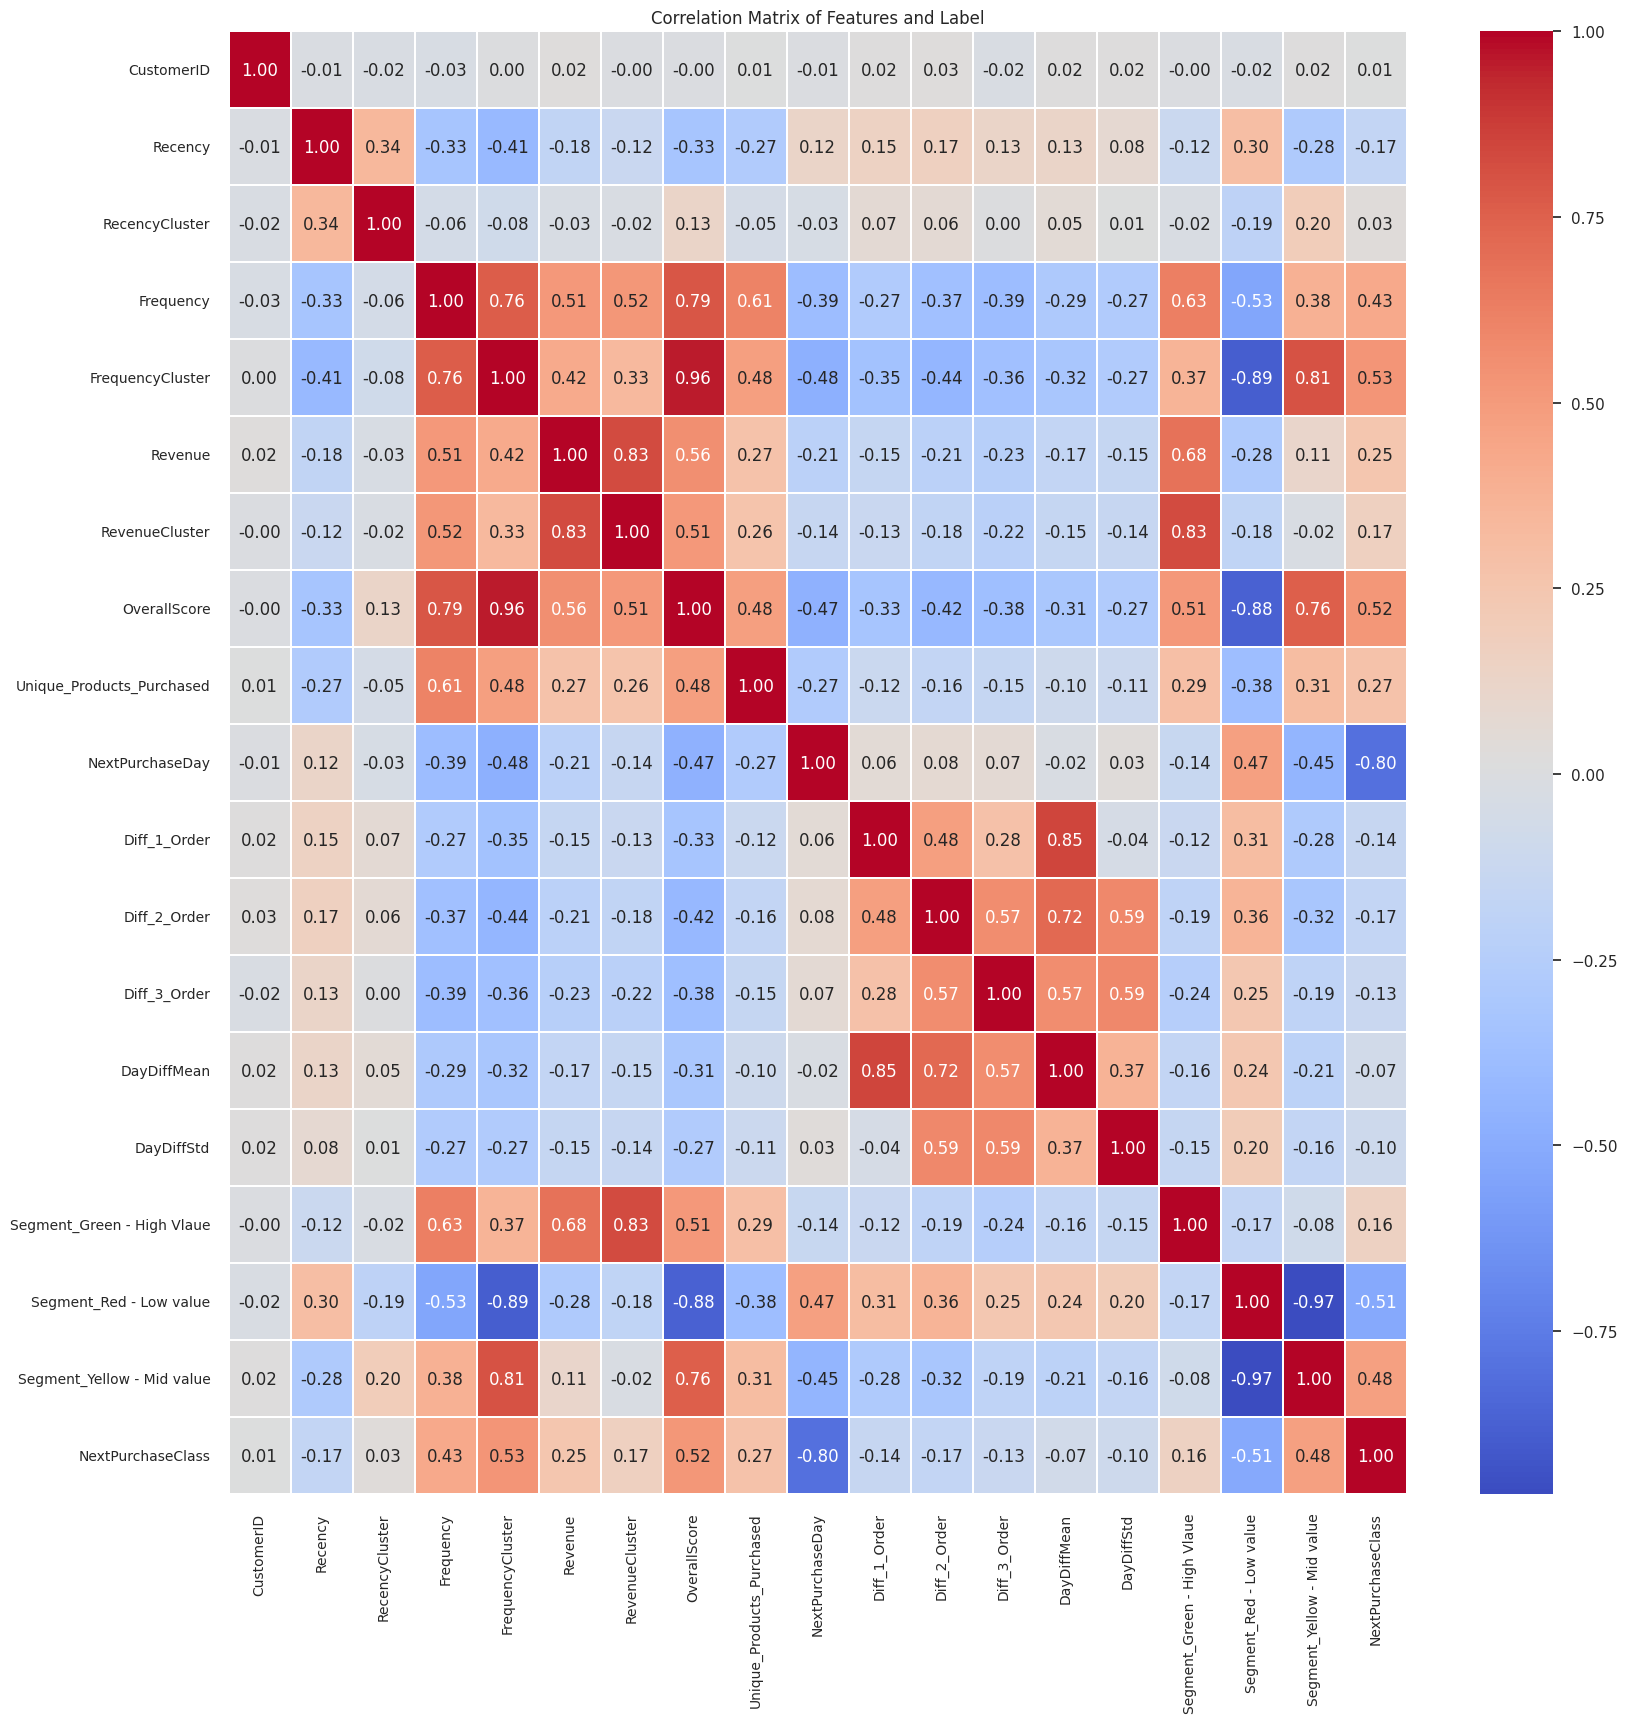

In [303]:
# Create a correlation matrix for a subset of relevant columns if necessary
# For instance, if df_model has many unrelated columns, specify only relevant ones:
# columns_of_interest = ['Feature1', 'Feature2', 'Label']
# corr = data_model[columns_of_interest].corr()

# If all columns in data_model are relevant:
corr = data_model.corr()

# Dynamically adjust the size of the plot based on the number of columns
plt.figure(figsize=(len(corr.columns), len(corr.columns)))

# Use a diverging color map for better visual distinction of correlations
sns.heatmap(corr, annot=True, linewidths=0.2, fmt=".2f", cmap='coolwarm')

# Improve readability by setting a title and adjusting font sizes if necessary
plt.title('Correlation Matrix of Features and Label')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Display the heatmap
plt.show()


In [304]:
# Building a Machine Learning Model

# Drop the NextPurchaseDay column
data_model = data_model.drop('NextPurchaseDay',axis=1)

# Select the prediction target varaible
y = data_model.NextPurchaseClass

# Features selection selecting all of the features expcet the taregt variable as we dont want it to act as an input
X = data_model.drop('NextPurchaseClass',axis=1)

# split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 101)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(1224, 17) (1224,)
(409, 17) (409,)


In [305]:
X.head()

CustomerID  Recency  RecencyCluster  Frequency  FrequencyCluster   Revenue  \
1       14688        7               0         27                 2   5055.61   
2       13767        1               0         52                 2  16945.71   
3       14849       21               0         28                 2   7904.28   
4       12921        3               0         50                 2  16389.74   
5       13468        1               0         41                 2   5656.75   

   RevenueCluster  OverallScore  Unique_Products_Purchased  Diff_1_Order  \
1               0             2                        148          12.0   
2               0             2                         55          13.0   
3               0             2                        159          22.0   
4               0             2                        233           2.0   
5               0             2                        184          14.0   

   Diff_2_Order  Diff_3_Order  DayDiffMean  DayDiffStd  \
1          21.0          35.0    22.666667   11.590226   
2          15.0          19.0    15.666667    3.055050   
3          57.0          87.0    55.333333   32.532035   
4           5.0          15.0     7.333333    6.806859   
5          27.0          34.0    25.000000   10.148892   

   Segment_Green - High Vlaue  Segment_Red - Low value  \
1                       False                    False   
2                       False                    False   
3                       False                    False   
4                       False                    False   
5                       False                    False   

   Segment_Yellow - Mid value  
1                        True  
2                        True  
3                        True  
4                        True  
5                        True

In [306]:
y.head()

1    2
2    2
3    2
4    2
5    2
Name: NextPurchaseClass, dtype: int64

In [307]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import KFold, cross_val_score

# Creating an array of models
models = [
    ("Random Forest", RandomForestClassifier()),
    ("Decision Tree", DecisionTreeClassifier()),
    ("XGBoost", XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
]

# Initialize variables
model_names = []
scores = []

# Measure the accuracy
for name, model in models:
    kfold = KFold(n_splits=2, shuffle=True, random_state=101)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring="accuracy")

    model_names.append(name)
    scores.append(cv_results)

# Create DataFrame after collecting all results
results_data = pd.DataFrame(scores, columns=['score_n1', 'score_n2'])
results_data['model'] = model_names

# Calculate the deviation between the scores
results_data['deviation'] = results_data['score_n1'] - results_data['score_n2']

# Print the results
results_data


score_n1  score_n2          model  deviation
0  0.633987  0.588235  Random Forest   0.045752
1  0.534314  0.529412  Decision Tree   0.004902
2  0.591503  0.581699        XGBoost   0.009804

In [308]:
# Build the Model as we have found there is low variance in XGBoost and Randomforest we now tune the model for better results

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Initialize the RandomForestClassifier
rf_model = RandomForestClassifier(random_state=101)

# Fit the model on the training data
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)

print('Accuracy of Random Forest classifier on test set: {:.2f}'.format(accuracy))


Accuracy of Random Forest classifier on test set: 0.61


In [309]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Initialize the RandomForestClassifier with specified hyperparameters
final_rf_model = RandomForestClassifier(
    n_estimators=100,        # Number of trees (you can tune this number based on your hyperparameter tuning results)
    max_depth=10,            # Maximum depth of trees
    min_samples_split=5,     # Minimum number of samples required to split an internal node
    min_samples_leaf=2,      # Minimum number of samples required to be at a leaf node
    random_state=101         # Seed for reproducibility
)

# Fit the RandomForest model on the training data
final_rf_model.fit(X_train, y_train)

# Calculate accuracy on the test set
accuracy = final_rf_model.score(X_test, y_test)

# Print the accuracy
print('Accuracy of final RandomForest model on test set: {:.2f}'.format(accuracy))

Accuracy of final RandomForest model on test set: 0.61


In [310]:
# predict next purchase class
predictions = final_rf_model.predict(X_test)

In [311]:
import pandas as pd

# Directly creating an output DataFrame using the indices to link CustomerID
output = pd.DataFrame({
    'CustomerID': data_model.loc[y_test.index, 'CustomerID'],  # Direct referencing using index from y_test
    'Actual': y_test,
    'Final Predictions': predictions
})

# Print the first few rows to ensure the merge is correct
print(output.head())

# Optionally, save to CSV for further analysis or sharing
output.to_csv('customer_predictions.csv', index=False)


      CustomerID  Actual  Final Predictions
3584       15916       0                  1
667        16770       0                  0
819        14684       0                  0
908        13680       0                  0
1451       15027       0                  1


In [312]:
xgb_model = xgb.XGBClassifier(random_state = 101).fit(X_train, y_train)

print('Accuracy of XGBoost classifier on test set: {:.2f}'
       .format(xgb_model.score(X_test[X_train.columns], y_test)))

Accuracy of XGBoost classifier on test set: 0.58


In [313]:
# fit the model using the XGBoost classifier
final_model = xgb.XGBClassifier(max_depth = 2, min_child_weight = 8, random_state = 101).fit(X_train, y_train)

print('Accuracy of final model on test set: {:.2f}'
       .format(final_model.score(X_test[X_train.columns], y_test)))

Accuracy of final model on test set: 0.61


In [314]:
# predict next purchase class
predictions = final_model.predict(X_test)

In [315]:
# link the results back to a customer and save
customers = data_model['CustomerID']
output = pd.DataFrame({'Actual': y_test,
                       'Final Predictions': predictions})
output = pd.merge(customers, output, left_index=True, right_index=True)
output.head(100)

CustomerID  Actual  Final Predictions
1          14688       2                  2
3          14849       2                  2
7          17381       2                  2
8          14180       2                  2
19         16168       2                  2
...          ...     ...                ...
1014       13168       0                  0
1015       17515       0                  0
1021       17075       0                  0
1023       17786       0                  0
1028       16918       1                  0

[100 rows x 3 columns]